# Data Processing

Notebook to process the input data (inkML files) and convert into images of individual symbols, which can be used to train the model

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

## About the data

The data used in this project was downloaded from Kaggle, here
https://www.kaggle.com/datasets/rtatman/handwritten-mathematical-expressions

Throughout the notebooks, I will assume that the data directory is called 'inkml_data', and exists in the main repo folder

In [208]:
import numpy as np
import os
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import shutil
import random

In [209]:
#random seed
np.random.seed(123)

The image data are in the form of inkML files, which follow an XML file structure.
Each file contains 1) information about the coordinates of each stroke. 2) which strokes form a single character, 3) the character label, and 4) some additional metadata.

I used this page: https://www.kaggle.com/code/kalikichandu/preprossing-inkml-to-png-files for help on how to parse inkML files. Some of the code in the following blocks is copied from there.

Let first look at this for one single file. Load in a file and get the root

In [210]:
train_files = glob.glob('../inkml_data/CROHME_training_2011/*inkml')
train_file = train_files[0]
print(f'loading file: {train_file}')
tree = ET.parse(train_file)
root = tree.getroot()

loading file: ../inkml_data/CROHME_training_2011/TrainData1_5_sub_21.inkml


Set the namespace (which is the same for all InkML files). We need this to get all the trace properties

In [211]:
doc_namespace = "{http://www.w3.org/2003/InkML}"

The full LateX label can be obtained as follows

In [212]:
full_eq = [label for label in root.findall(doc_namespace + 'annotation') if label.attrib == {'type': 'truth'}]
full_eq[0].text

'A = \\sqrt{a + \\frac{1}{\\sqrt{a + \\frac{1}{\\sqrt{a}}}}} + \\sqrt{b}'

Extract info from all the traces

In [213]:
ids = []
coords = []
for trace_tag in root.findall(doc_namespace + 'trace'):
    ids.append(trace_tag.get('id'))
    coords.append(trace_tag.text.strip())

This obtains the ids and the coordinates for each individual stroke, or 'trace'. <br>
Now let's split the coordinates in x and y, and plot the image

In [214]:
xx = []
yy = []
for i in range(len(coords)):
    
    x = coords[i].split(' ')[::2]
    xx.append([float(coord) for coord in x])
    
    y = coords[i].split(' ')[1::2]
    yy.append([float(coord[:-1]) for coord in y])

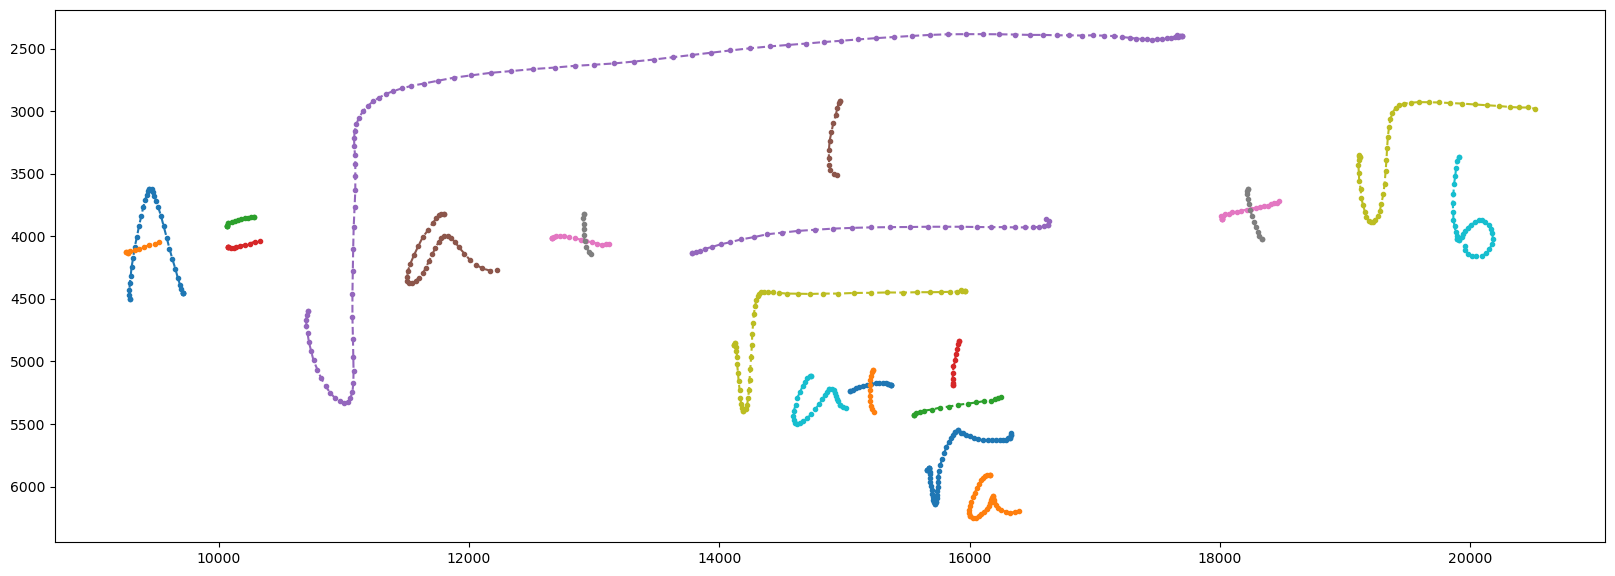

In [215]:
fig, ax = plt.subplots(figsize=(20, 8))
for i in range(len(xx)):
    ax.plot(xx[i][:-1], yy[i][:-1], marker='o', markersize=3, linestyle='dashed') #for some reason the last coord is not part of the trace
ax.set_aspect('equal', adjustable='box') #since this is writing it's important to have equal ax scales
ax.invert_yaxis() #for some reason y=0 is at the top

Some characters (like the capital A and the equal sign in the above example) actually consist of multiple traces. I'll need the 'traceGroup' property so that I can figure out which traces belong together. I'll also need the label for that traceGroup.

Sidenote: the above image illustrates pretty well why rendering an equation out of individual symbols is not a trivial problem: the symbols symbols aren't neatly side-by-side, and their location with respect to each other should change the way that the final equation is rendered (in this example, particularly in the fraction).

In [216]:
traceGroupWrapper = root.find(doc_namespace + 'traceGroup')
if traceGroupWrapper is not None:
    for traceGroup in traceGroupWrapper.findall(doc_namespace + 'traceGroup'):

        label = traceGroup.find(doc_namespace + 'annotation').text
        print(f'Label:   {label}')
        
        #traces of the current traceGroup
        trace_ids = []
        for traceView in traceGroup.findall(doc_namespace + 'traceView'):
            traceDataRef = int(traceView.get('traceDataRef'))
            trace_ids.append(traceDataRef)

        print('trace ids:', trace_ids)


Label:   A
trace ids: [0, 1]
Label:   =
trace ids: [2, 3]
Label:   \sqrt
trace ids: [4]
Label:   a
trace ids: [5]
Label:   +
trace ids: [6, 7]
Label:   -
trace ids: [14]
Label:   1
trace ids: [15]
Label:   \sqrt
trace ids: [8]
Label:   a
trace ids: [9]
Label:   +
trace ids: [10, 11]
Label:   -
trace ids: [12]
Label:   1
trace ids: [13]
Label:   \sqrt
trace ids: [20]
Label:   a
trace ids: [21]
Label:   +
trace ids: [16, 17]
Label:   \sqrt
trace ids: [18]
Label:   b
trace ids: [19]


Putting all of the above together, I want to
1) extract the traces that belong to a group, and the label of that group
2) plot each tracegroup individually, and save this as an image that I can use to train the model on
3) Rinse and repeat for each image

In [217]:
def extract_tracegroup_info(inkML_file):
    """
    Extract tracegroup and label information from an inkML file
    Returns: 
        a dictionary, where each entry contains a single traceGroup
        key: label_charnumber 
        value: a list of lists, where each list is the coordinates for a single trace within the traceGroup
    """
    tree = ET.parse(inkML_file)
    root = tree.getroot()

    traces_dict = {}
    for trace_tag in root.findall(doc_namespace + 'trace'):
        #assign trace id and coords as a key-value pair
        traces_dict[int(trace_tag.get('id'))] = trace_tag.text.strip()

    traceGroup_dict = {}
    traceGroupWrapper = root.find(doc_namespace + 'traceGroup')
    if traceGroupWrapper is not None:
        for j, traceGroup in enumerate(traceGroupWrapper.findall(doc_namespace + 'traceGroup')):

            label = traceGroup.find(doc_namespace + 'annotation').text
            tkey = label + '_' + str(j)
            traceGroup_dict[tkey] = []
            for traceView in traceGroup.findall(doc_namespace + 'traceView'):
                traceDataRef = int(traceView.get('traceDataRef'))
                traceGroup_dict[tkey].append([traces_dict[traceDataRef]])
    return traceGroup_dict

In [218]:
traceGroup_dict = extract_tracegroup_info(train_files[0])
traceGroup_dict.keys()

dict_keys(['A_0', '=_1', '\\sqrt_2', 'a_3', '+_4', '-_5', '1_6', '\\sqrt_7', 'a_8', '+_9', '-_10', '1_11', '\\sqrt_12', 'a_13', '+_14', '\\sqrt_15', 'b_16'])

I had to append the characternumber at the end there to avoid two characters with the same label being lumped together. But it looks like this will work.
Now let's write another function to save each character as an image

In [219]:
def convert_coordinates(coords):
    """
    Convert input coordinate list (which are in strings in the format [xx yy, xx yy, ...] into numerical x and y coordinate lists
    Returns:
        list of x and y coordinates
    """
    
    xx = [float(coord) for coord in coords[0].split(' ')[::2]]
    yy = [float(coord.split(',')[0]) for coord in coords[0].split(' ')[1::2]] 

    return xx, yy

Note: opening and saving many figures in matplotlib results in memory issues over time, even when I call plt.close(fig) or explicitly delete the fig. And garbage collecting seems to slow things down over time, as well. That's why I decided to simply use the same fig and ax objects every loop. I create them once, and then pass it through the function so I can re-use them in every iteration. See also: https://github.com/matplotlib/matplotlib/issues/8519

In [220]:
def process_traceGroup_image(tracelabel, coords_ll, fig, ax, output_dir='processed_dir', file_nr=0, lw=2):
    """
    Plot an input set of traceGroup coordinates, and save as an image with the labelname part of the filename
    """
    ax.clear()
    for coords in coords_ll: #coordinates of individual traces
        xcoords, ycoords = convert_coordinates(coords)
        ax.plot(xcoords, ycoords, color='black', linewidth=lw)
    ax.set_aspect('equal', adjustable='box') #since this is writing it's important to have equal ax scales
    ax.invert_yaxis() #for some reason y=0 is at the top
    
    #get rid of border, ticks, and ticklabels
    ax.set_frame_on(False)
    ax.tick_params(axis='both',which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
    
    #save 
    if tracelabel[0] == '/': tracelabel = 'adiv' + tracelabel[1:] #because a '/' will not be interpreted as part of the filename
    filename = tracelabel + '_' + str(file_nr)
    fig.savefig(output_dir + '/' + filename)
    
    return fig, ax

Now we can go ahead and process the traceGroup images for this fil

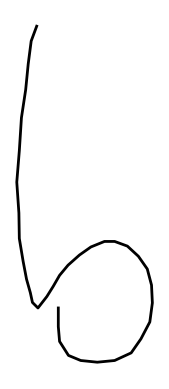

In [221]:
processed_dir = '../img_data/train_symbols/'
fig, ax = plt.subplots() #i

if os.path.isdir(processed_dir) == False: os.mkdir(processed_dir) #to save the images
for k,v in traceGroup_dict.items():
    fig, ax = process_traceGroup_image(k, v, fig, ax, processed_dir, 'test', lw=2)

From visually inspecting the files, that looks pretty good!

In [222]:
#delete the test images
rm_files = glob.glob(processed_dir + '*png')
for file in rm_files: os.remove(file)

### Saving Isolated Symbols

I want to repeat this procedure of this for the all the files. Let's first get a list of all the training data

In [223]:
train_dirs = ['CROHME_training_2011', 'trainData_2012_part1', 'trainData_2012_part2', 'TrainINKML_2013']
tot_files = []
for train_dir in train_dirs:
    tfiles = glob.glob('../inkml_data/' + train_dir + '/*inkml')
    tot_files.extend(tfiles)

As a final point of consideration - I want the model to be able to train on symbols with different sizes. I will randomly drawing linewidth values from a normal distribution.

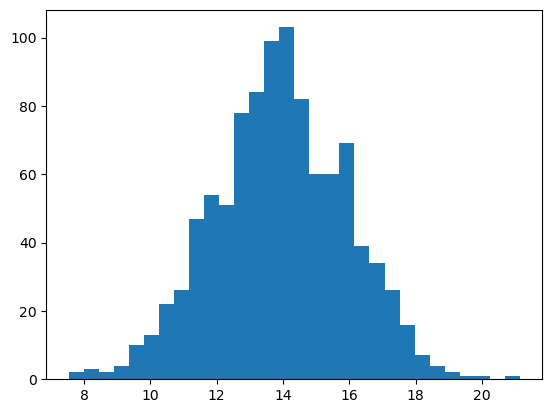

In [224]:
lw_samples = np.random.normal(loc=14, scale=2, size=1000)
plt.hist(lw_samples,bins=30);

The following code will create about 400 MB of images, and (on my machine) takes more than an hour to run

Note: the files in the 2013 INKML dataset with the 'MfrDB' label have weird coordinate systems (notation (xxx yyy zzzzzz,...) and I haven't been able to figure out how those add up to x and y coordinates. Therefore I'll exclude them for now.

Processed 0 out of 11095 inkML files
Processed 250 out of 11095 inkML files
Processed 500 out of 11095 inkML files
Processed 750 out of 11095 inkML files
Processed 1000 out of 11095 inkML files
Processed 1250 out of 11095 inkML files
Processed 1500 out of 11095 inkML files
Processed 1750 out of 11095 inkML files
Processed 2000 out of 11095 inkML files
Processed 2250 out of 11095 inkML files
Processed 2500 out of 11095 inkML files
Processed 2750 out of 11095 inkML files
Processed 3000 out of 11095 inkML files
Processed 3250 out of 11095 inkML files
Processed 3500 out of 11095 inkML files
Processed 3750 out of 11095 inkML files
Processed 4000 out of 11095 inkML files
Processed 4250 out of 11095 inkML files
Processed 4500 out of 11095 inkML files
Processed 4750 out of 11095 inkML files
Processed 5000 out of 11095 inkML files
Processed 5250 out of 11095 inkML files
Processed 5500 out of 11095 inkML files
Processed 5750 out of 11095 inkML files
Processed 6000 out of 11095 inkML files
Proces

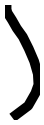

In [228]:
label_list = [] #to keep track of the total number of unique labels
fig, ax = plt.subplots(figsize=(3, 3), dpi=50) #calling it once and then re-using it for every image to avoid memory issues

#I want to save larger symbols with a smaller linewidth
larger_symbols = ['\\sin', '\\tan', '\\cos', '\\log', '\\lim', '\\sum']
for i, file in enumerate(tot_files):
    if i%250==0: print(f'Processed {i} out of {len(tot_files)} inkML files')
    if 'MfrDB' in  file: continue
    traceGroup_dict = extract_tracegroup_info(file)
    for t, (k,v) in enumerate(traceGroup_dict.items()):
        label_list.append(k.split('_')[0])
        if k.split('_')[0] in larger_symbols:
            lw_loc = 9
        else:
            lw_loc = 14
        fig, ax = process_traceGroup_image(k, v, fig, ax, processed_dir, i, lw=np.random.normal(loc=lw_loc, scale=2))

Now let's change the file structure into a format that we can easily feed to keras image_dataset_from_directory

In [229]:
all_files = glob.glob(processed_dir + '*png')

In [230]:
label_file_dict = {}
for file in all_files:
    label = file.split('/')[-1].split('_')[0]
    if (label.isalpha() == True) and (label == label.upper()):
        label = 'capital_' + label
    dirname = processed_dir + 'label_' + label
    if os.path.isdir(dirname) == False: 
        os.mkdir(dirname)
        label_file_dict[label] = 1
    else:
        label_file_dict[label] += 1
    new_filename = 'img_' + str(label_file_dict[label]) + '.png'
    
    shutil.copy(file, dirname + '/' + new_filename)

In [231]:
print(label_file_dict.keys())

dict_keys(['\\log', '\\int', 'a', '-', '2', '=', 'adiv', '\\prime', '1', '\\pi', 'm', 'j', '0', '\\theta', 'b', '6', 'x', '+', 'z', 't', '\\beta', 'n', 'c', '\\geq', '\\sin', '3', '(', 'd', 'e', '\\lt', 'capital_P', '8', '\\sum', 'y', '\\times', ')', 'capital_X', '4', '\\sqrt', '\\}', 'k', 'u', 's', '\\lim', 'i', 'capital_B', 'v', '\\ldots', 'capital_A', 'p', '[', '9', 'capital_R', 'capital_N', '!', '\\{', '\\alpha', 'capital_G', '\\cos', '\\neq', '\\pm', ',', 'q', '\\gamma', '\\tan', '5', '7', '\\phi', ']', 'capital_C', 'l', 'capital_F', 'r', '\\rightarrow', '\\mu', 'o', '\\leq', 'w', 'f', '|', 'h', 'capital_Y', '\\sigma', 'g', 'capital_E', 'capital_M', '\\infty', 'capital_S', 'capital_V', 'capital_L', '\\div', '\\in', 'capital_H', '\\Delta', 'capital_I', '\\lambda', '\\exists', 'capital_T', '\\gt', '\\forall'])


Now we can remove all the files I just copied from

In [121]:
files_to_remove = glob.glob(processed_dir + '*png')
for file in files_to_remove:
    os.remove(file)

### Saving full equations

Secondly, I'd also like to save some full equations as images, so that I can figure out how well I can use opencv's findContours() function to resolve individual symbols within an equation, and to test how well my pipeline works ultimately

In [201]:
full_eq_dir = '../img_data/full_equations/'
if os.path.isdir(full_eq_dir) == False: os.mkdir(full_eq_dir)

train_dirs = ['CROHME_training_2011', 'trainData_2012_part1', 'trainData_2012_part2']
full_eq_files = []
for train_dir in train_dirs:
    tfiles = glob.glob('../inkml_data/' + train_dir + '/*inkml')
    full_eq_files.extend(tfiles)

In [196]:
random.shuffle(full_eq_files)
full_eq_files = full_eq_files[:1000]

In [197]:
def get_full_eq_label(inkML_file):
    """
    Given an input inkML file, return the full equation string
    """
    tree = ET.parse(inkML_file)
    root = tree.getroot()
    full_eq = [label for label in root.findall(doc_namespace + 'annotation') if label.attrib == {'type': 'truth'}]
    return full_eq[0].text

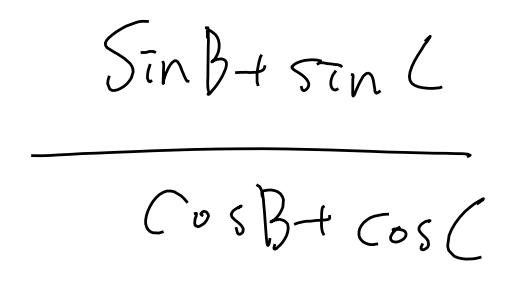

In [198]:
write_eq = open(full_eq_dir + 'eq_labels.txt', 'w')
    
fig, ax = plt.subplots()
for i, file in enumerate(full_eq_files): #this is going to take a while :)
    traceGroup_dict = extract_tracegroup_info(file)
    full_eq_string = get_full_eq_label(file)
    write_eq.write(full_eq_string + ' \n')
    tot_coords = []
    for k,v in traceGroup_dict.items():
        tot_coords.extend(v)
    fig, ax = process_traceGroup_image('full_eq', tot_coords, fig, ax, full_eq_dir, i)
    
write_eq.close()

In [204]:
test_d = glob.glob('../inkml_data/TrainINKML_2013/*inkml')

for file in test_d:
    print(file)
    full_eq_string = get_full_eq_label(file)

../inkml_data/TrainINKML_2013/65_herbert.inkml
../inkml_data/TrainINKML_2013/2009213-139-221.inkml
../inkml_data/TrainINKML_2013/2009213-137-152.inkml
../inkml_data/TrainINKML_2013/formulaire039-equation022.inkml
../inkml_data/TrainINKML_2013/200924-1312-132.inkml
../inkml_data/TrainINKML_2013/2009212-952-43.inkml
../inkml_data/TrainINKML_2013/2009213-137-117.inkml
../inkml_data/TrainINKML_2013/formulaire039-equation067.inkml
../inkml_data/TrainINKML_2013/200924-1312-177.inkml
../inkml_data/TrainINKML_2013/200923-131-78.inkml
../inkml_data/TrainINKML_2013/200923-1553-139.inkml
../inkml_data/TrainINKML_2013/2009210-947-44.inkml
../inkml_data/TrainINKML_2013/TrainData1_5_sub_21.inkml
../inkml_data/TrainINKML_2013/2009210-947-124.inkml
../inkml_data/TrainINKML_2013/KME1G3_4_sub_21.inkml
../inkml_data/TrainINKML_2013/TrainData2_19_sub_98.inkml
../inkml_data/TrainINKML_2013/formulaire010-equation061.inkml
../inkml_data/TrainINKML_2013/2009210-947-161.inkml
../inkml_data/TrainINKML_2013/2009

ParseError: not well-formed (invalid token): line 15, column 23 (<string>)